**Setup**

In [10]:
# Import packages
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import pickle
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_folder_path = '/Users/andrewseastream/Documents/Documents/Ellington/Data/'

**Create Dataset**

In [ ]:
# Read SBA 504 data
file_name = 'foia-504-fy2010-present-asof-230930.csv'
sbadata = pd.read_csv(data_folder_path + file_name)

# Create a loan id
sbadata['LoanID'] = range(1, len(sbadata) + 1)

# Remove if never funded
sbadata = sbadata.query("LoanStatus not in ['CANCLD', 'NOT FUNDED']")
sbadata = sbadata.query("LoanStatus.notna()")

# Convert dates
sbadata['AsOfDate'] = pd.to_datetime(sbadata['AsOfDate'], format='%Y%m%d')
sbadata['AsOfDate'] = sbadata['AsOfDate'].dt.to_period('M').dt.to_timestamp()
sbadata['ApprovalDate'] = pd.to_datetime(sbadata['ApprovalDate'], format='%m/%d/%Y')
sbadata['ApprovalDate'] = sbadata['ApprovalDate'].dt.to_period('M').dt.to_timestamp()
sbadata['PaidInFullDate'] = pd.to_datetime(sbadata['PaidInFullDate'], format='%m/%d/%Y')
sbadata['PaidInFullDate'] = sbadata['PaidInFullDate'].dt.to_period('M').dt.to_timestamp()
sbadata['ChargeOffDate'] = pd.to_datetime(sbadata['ChargeOffDate'], format='%m/%d/%Y')
sbadata['ChargeOffDate'] = sbadata['ChargeOffDate'].dt.to_period('M').dt.to_timestamp()
sbadata['LastDate'] = np.where(sbadata['ChargeOffDate'].notna(), sbadata['ChargeOffDate'],
                               np.where(sbadata['PaidInFullDate'].notna(), sbadata['PaidInFullDate'],
                                        sbadata['AsOfDate']))
sbadata['MaturityDate'] = sbadata.apply(lambda row: row['ApprovalDate'] + pd.DateOffset(months=row['TermInMonths']), axis=1)

# Create dynamic data
createdynamicdata = False
if createdynamicdata:
    def generate_month_range(start, end):
        return pd.date_range(start=start, end=end, freq='MS').tolist()

    sbadata['Months'] = sbadata.apply(lambda row: generate_month_range(row['ApprovalDate'], row['LastDate']), axis=1)
    sbadata_dyn = sbadata.explode('Months')
    sbadata_dyn = sbadata_dyn.rename(columns={'Months': 'Date'}).reset_index(drop=True)
    sbadata.drop(columns='Months', inplace=True)
    sbadata_dyn = sbadata_dyn[['Date'] + ['LoanID'] + [col for col in sbadata_dyn.columns if col not in ['Date', 'LoanID']]]
    sbadata_dyn.to_pickle(data_folder_path + 'sbadata_dyn_initial.pkl')
else:
    sbadata_dyn = pd.read_pickle(data_folder_path + 'sbadata_dyn_initial.pkl')

# Classify prepayments and charge offs
sbadata_dyn['Prepayment'] = np.where((sbadata_dyn['Date'] == sbadata_dyn['PaidInFullDate']) &
                                     (sbadata_dyn['Date'] < sbadata_dyn['MaturityDate']), 1, 0)
sbadata_dyn['Prepayment Next Month'] = np.where((sbadata_dyn['Date'] + pd.DateOffset(months=1) == sbadata_dyn['PaidInFullDate']) &
                                     (sbadata_dyn['Date'] + pd.DateOffset(months=1) < sbadata_dyn['MaturityDate']), 1, 0)
sbadata_dyn['ChargeOff'] = np.where(sbadata_dyn['Date'] == sbadata_dyn['ChargeOffDate'], 1, 0)

# Calculate extra columns
sbadata_dyn['Loan Age'] = ((sbadata_dyn['Date'].dt.year - sbadata_dyn['ApprovalDate'].dt.year) * 12) + (sbadata_dyn['Date'].dt.month - sbadata_dyn['ApprovalDate'].dt.month)
rates_df = pd.read_csv(data_folder_path + 'SBA 504 Historical Rates.csv')
rates_df['Date'] = pd.to_datetime(rates_df['Date'])
sbadata_dyn = sbadata_dyn.merge(rates_df, on='Date', how='left').rename(columns={'Rate': 'Obs Market Rate'})
sbadata_dyn = sbadata_dyn.merge(rates_df.rename(columns={'Date':'ApprovalDate'}), on='ApprovalDate', how='left').rename(columns={'Rate': 'Orig Market Rate'})
sbadata_dyn['Incentive'] = sbadata_dyn['Orig Market Rate'] - sbadata_dyn['Obs Market Rate']
sbadata_dyn['Rounded Incentive'] = sbadata_dyn['Incentive'].round(decimals=1)

# Merge in macro data
macrodata = pd.read_csv(data_folder_path + 'MacroData.csv')
macrodata['Date'] = pd.to_datetime(macrodata['Date'])
sbadata_dyn = sbadata_dyn.merge(macrodata, on='Date', how='left')

# Restrict to records in 2010 or later
sbadata_dyn = sbadata_dyn[sbadata_dyn['Date'].dt.year >= 2010]

# Save dataframe
sbadata_dyn.to_pickle(data_folder_path + 'sbadata_dyn.pkl')

##################################################

**Create CPR Model**

In [2]:
# Download data
sbadata_dyn = pd.read_pickle(data_folder_path + 'sbadata_dyn.pkl')
sbadata_dyn['Date'] = pd.to_datetime(sbadata_dyn['Date'])
sbadata_dyn['ApprovalDate'] = pd.to_datetime(sbadata_dyn['ApprovalDate'])

In [5]:
# Restrict by date
train_data = sbadata_dyn[(sbadata_dyn['Date'] < pd.to_datetime('2023-09-01')) & (sbadata_dyn['Prepayment'] == 0)]

# Set training columns
X = train_data[['Loan Age', 'GrossApproval', 'Incentive', 'UnempRate']]
y = train_data['Prepayment Next Month']

# Split the data into training and validation sets
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the XGBClassifier on the training set
model = XGBClassifier(max_depth=2)
model.fit(X_train, y_train)

# Predict probabilities for the entire dataset
y_pred_entire = model.predict_proba(sbadata_dyn[['Loan Age', 'GrossApproval', 'Incentive', 'UnempRate']])

# Extract the probabilities for the positive class
prob_class_1_entire = y_pred_entire[:, 1]

# Add these probabilities to the original DataFrame
sbadata_dyn['Model Prepayment Next Month'] = prob_class_1_entire

# Merge in model prepayment to next month
sbadata_dyn.drop(columns='Model Prepayment', inplace=True)
sbadata_dyn['Next Month'] = sbadata_dyn['Date'] + pd.DateOffset(months=1)
sbadata_dyn = sbadata_dyn.merge(sbadata_dyn[['LoanID', 'Next Month', 'Model Prepayment Next Month']].rename(columns={'Next Month':'Date',
                                                                                                           'Model Prepayment Next Month':'Model Prepayment'}),
                                on=['LoanID', 'Date'], how='left')
sbadata_dyn.drop(columns='Next Month', inplace=True)

# Save
sbadata_dyn.to_pickle(data_folder_path + 'sbadata_dyn.pkl')

In [9]:
# Save smaller file
columns_to_keep = ['Date', 'LoanID', 'ThirdPartyDollars', 'GrossApproval', 'ApprovalDate', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths',
                   'NaicsDescription', 'ProjectState', 'BusinessType', 'BusinessAge', 'JobsSupported', 'MaturityDate', 'Prepayment', 'ChargeOff',
                   'Loan Age', 'Obs Market Rate', 'Orig Market Rate', 'Incentive', 'Model Prepayment',
                   'UnempRate', 'US10YrTRate']
sbadata_dyn[columns_to_keep].sample(frac=0.114, random_state=42).to_pickle(data_folder_path + 'sbadata_dyn_small.pkl')

In [11]:
# Store model
pickle.dump(model, open('cpr_model.pkl', 'wb'))

In [ ]:
# Download data
sbadata_dyn = pd.read_pickle(data_folder_path + 'sbadata_dyn_small.pkl')
sbadata_dyn['Date'] = pd.to_datetime(sbadata_dyn['Date'])
sbadata_dyn['ApprovalDate'] = pd.to_datetime(sbadata_dyn['ApprovalDate'])

**Model Validation Plot**

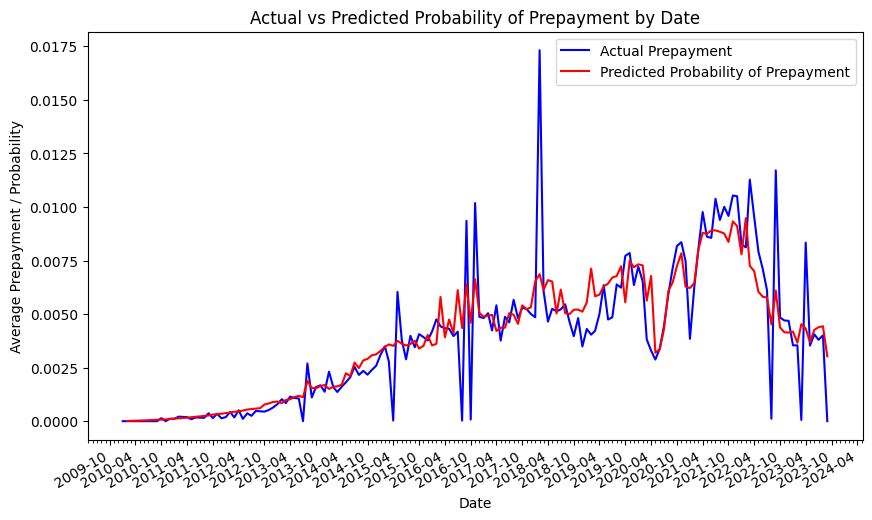

In [6]:
##### Plot by Variable #####

variable = 'Date'

# Group by variable and calculate the averages
grouped_data = sbadata_dyn.groupby(variable).agg({'Prepayment': 'mean', 'Model Prepayment': 'mean'}).reset_index()

# Convert 'Date' to datetime in grouped_data if it's not already
if variable == 'Date':
    grouped_data['Date'] = pd.to_datetime(grouped_data['Date'])

# Plot the results
plt.figure(figsize=(10, 6))

# Plotting
plt.plot(grouped_data['Date'], grouped_data['Prepayment'], label='Actual Prepayment', color='blue')
plt.plot(grouped_data['Date'], grouped_data['Model Prepayment'], label='Predicted Probability of Prepayment', color='red')

# Formatting the date axis
# Using a less frequent locator and a simpler date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # A label every three months
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Minor ticks for months

plt.gcf().autofmt_xdate()  # Auto format the date labels

plt.xlabel('Date')
plt.ylabel('Average Prepayment / Probability')
plt.title('Actual vs Predicted Probability of Prepayment by Date')
plt.legend()
plt.show()

##################################################